In [1]:
import functools
import itertools
import os
import re
from collections import defaultdict, namedtuple
from pathlib import Path
import toolz
from dataclasses import dataclass

import more_itertools

# Data preprocessing

In [2]:
RAW_DATA_BASEDIR = Path('../data/raw')
!ls -lht {RAW_DATA_BASEDIR}

raw_files_path = {
    'query': RAW_DATA_BASEDIR / 'CISI.QRY',
    'all': RAW_DATA_BASEDIR / 'CISI.ALL',
    'rel': RAW_DATA_BASEDIR / 'CISI.REL',
}


total 6200
-rw-r--r--  1 marcospiau  staff    79K Feb 21 23:00 CISI.REL
-rw-r--r--  1 marcospiau  staff   2.1M Feb 21 22:05 CISI.ALL
-rw-r--r--  1 marcospiau  staff   757K Feb 21 13:55 cisi.tar.gz
-rw-r--r--  1 marcospiau  staff    67K Feb 28  1994 CISI.QRY
-rw-r--r--  1 marcospiau  staff   4.5K Feb 28  1994 CISI.BLN


Arquivos QRY e ALL são mais complicados e precisam de processamento. Tentei deixar processamento semelhante pra conseguir fazer os dois casos com uma mesma funcao:

In [5]:
# (.I) ID
# (.T) Title
# (.W) Abstract
# (.B) Publication date of the article
# (.A) Author list
# (.N) Information when entry was added
# (.X) List of cross-references to other documents

renames_docs_all = {
    '.I': 'id',
    '.T': 'title',
    '.W': 'abstract',
    '.B': 'publication_date',
    '.A': 'author_list',
    '.N': 'added_date',
    '.X': 'cross_references'
}

process_doc_all = toolz.compose_left(
    # for each tag, get renamed tag, and join texts for tag
    functools.partial(more_itertools.map_reduce,
                      keyfunc=lambda x: renames_docs_all[x.tag],
                      valuefunc=lambda x: x.text,
                      reducefunc=lambda x: ' '.join(x)),
    # keeps only desired keys
    toolz.curried.keyfilter(lambda x: x in {'id', 'title', 'abstract'}),
    # convert id to int
    toolz.curried.update_in(keys=['id'], func=int)
)

# (.I) ID
# (.W) Query
# (.A) Author list
# (.N) Authors name and some keywords on what the query searches for

renames_docs_queries = {
    '.I': 'id',
    '.W': 'query',
    '.T': 'title',
    '.A': 'author_list',
    # '.N': 'other_query_infos',
    '.B': 'publication_date',
    # '.X': 'cross_references'
}

process_doc_qry = toolz.compose_left(
    functools.partial(more_itertools.map_reduce,
                      keyfunc=lambda x: renames_docs_queries[x.tag],
                      valuefunc=lambda x: x.text,
                      reducefunc=lambda x: ' '.join(x)),
    toolz.curried.keyfilter(lambda x: x in {'id', 'query'}),
    toolz.curried.update_in(keys=['id'], func=int))

In [42]:
import itertools
import re
from typing import Any, Callable, Dict, Iterable, List, Tuple, Union


@dataclass
class IdTagText:
    id: str
    tag: str
    text: str


def parse_cisi_all_or_qry(
    path: str,
    process_doc_fn: Callable[[Iterable[IdTagText]], Dict[str, Any]],
    return_dict: bool = False,
) -> Union[List[Dict[str, Any]], Dict[str, Any]]:
    """Parses a CISI all or query file.

    Args:
        path: A string representing the path to the file to parse.
        process_doc_fn: A function that receives a list of IdTagText or an iterable of
          IdTagText as input, and returns a dictionary.
        return_dict: A boolean indicating whether to return a dictionary or a list of
          dictionaries.

    Returns:
        If return_dict is True, a dictionary with the document IDs as keys and
        processed documents as values. Otherwise, a list of processed documents.

    Raises:
        AssertionError: If the document IDs are not unique.
    """
    markers = [r'^\.I\s(\d+)$', '\.T$', '\.A$', '\.B$', '\.W$', '\.X$', '\.N$']
    marker_pattern = re.compile('|'.join(markers))

    def gen_items() -> Iterable[IdTagText]:
        with open(path, 'r') as f:
            for line in map(str.strip, f):
                match = marker_pattern.match(line)
                # match occurs for lines with tags
                if match:
                    # if match.group(1) is not None, it means that the tag is .I
                    # and the group contains the ID
                    if match.group(1):
                        id_ = match.group(1)
                        yield IdTagText(id_, '.I', id_)
                    else:
                        tag = match.group(0).strip()
                else:
                    # if match is None, it means that the line is a text
                    # just propagate tag and id
                    yield IdTagText(id_, tag, line)

    out = [
        process_doc_fn(group)
        for _, group in itertools.groupby(gen_items(), key=lambda x: x.id)
    ]
    assert len(out) == len({x['id'] for x in out}), 'IDs are not unique'
    return {x['id']: x for x in out} if return_dict else out


process_cisi_all = functools.partial(parse_cisi_all_or_qry,
                                     process_doc_fn=process_doc_all)
process_cisi_qry = functools.partial(parse_cisi_all_or_qry,
                                     process_doc_fn=process_doc_qry)

In [44]:
corpus = process_cisi_all(raw_files_path['all'])
corpus[0]

{'id': 1,
 'title': '18 Editions of the Dewey Decimal Classifications',
 'abstract': "The present study is a history of the DEWEY Decimal Classification.  The first edition of the DDC was published in 1876, the eighteenth edition in 1971, and future editions will continue to appear as needed.  In spite of the DDC's long and healthy life, however, its full story has never been told.  There have been biographies of Dewey that briefly describe his system, but this is the first attempt to provide a detailed history of the work that more than any other has spurred the growth of librarianship in this country and abroad."}

In [45]:
queries = process_cisi_qry(raw_files_path['query'])
queries[0]

{'id': 1,
 'query': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'}

In [56]:
def normalize_and_tokenize(text):
    """Normalize text and toikenize it."""
    # use regex for replacing
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
    return re.sub(r'[^\w\s]', '', text).lower().split()


In [400]:
def load_qrels(path):
    out = defaultdict(set)
    with open(path, 'r') as f:
        for line in map(str.strip, f):
            qid, docid, _, _ = line.split()
            out[int(qid)].add(int(docid))
    out.default_factory = None

    return out

load_qrels(raw_files_path['rel'])[1]

{28,
 35,
 38,
 42,
 43,
 52,
 65,
 76,
 86,
 150,
 189,
 192,
 193,
 195,
 215,
 269,
 291,
 320,
 429,
 465,
 466,
 482,
 483,
 510,
 524,
 541,
 576,
 582,
 589,
 603,
 650,
 680,
 711,
 722,
 726,
 783,
 813,
 820,
 868,
 869,
 894,
 1162,
 1164,
 1195,
 1196,
 1281}

In [46]:
import pandas as pd
df = pd.read_csv(raw_files_path['rel'], delim_whitespace=True, header=None).astype(str)
display(df.describe())
del df


,0,1,2,3
count,3114,3114,3114,3114
unique,76,1162,1,1
top,44,375,0,0.0
freq,155,15,3114,3114


# Classe BM25

In [277]:
%%time
import math
from collections import Counter
from typing import List, Tuple


class BM25:
    """Class to calculate BM25 ranking for a given set of queries and documents.
    
    BM25 is a ranking function used in Information Retrieval to rank search results based on relevance to a query.
    This class implements the BM25 algorithm, which uses document term frequencies and query term frequencies
    to calculate a relevance score for each document.
    
    Attributes:
        corpus: List of documents, where each document is a list of terms.
        k1: Hyperparameter that controls the term frequency saturation. Default is 1.2.
        b: Hyperparameter that controls the document length normalization. Default is 0.75.
        epsilon: Smoothing factor to avoid division by zero. Default is 0.25.
        idf: Dictionary containing the inverse document frequency for each term in the corpus.
        avgdl: Average document length in the corpus.
    """
    
    def __init__(self, corpus: List[List[str]], k1: float = 1.2, b: float = 0.75, epsilon: float = 0.25):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        self.idf = self._calculate_idf()
        self.avgdl = sum(map(len, corpus)) / len(corpus)

    def _calculate_idf(self) -> dict:
        """Calculate the inverse document frequency for each term in the corpus."""
        # idf = defaultdict(int)
        idf = {}
        for document in self.corpus:
            for term in set(document):
                idf[term] = idf.get(term, 0) + 1
                # idf[term] += 1
        for term in idf:
            idf[term] = math.log(len(self.corpus) / (idf[term] + self.epsilon))
        return idf

    def score(self, query: List[str], doc_id: int) -> float:
        """Calculate the relevance score of a document for a given query.
        
        Args:
            query: List of terms in the query.
            doc_id: ID of the document in the corpus.
            
        Returns:
            Relevance score of the document for the query.
        """
        doc = self.corpus[doc_id]
        tf = Counter(doc)
        score = 0
        for term in query:
            if term in doc:
                score += self.idf[term] * tf[term] * (self.k1 + 1) / (tf[term] + self.k1 * (1 - self.b + self.b * len(doc) / self.avgdl))
        return score
    
    def retrieve(self, queries: List[List[str]], k: int = 10) -> List[Tuple[int, float]]:
        """Retrieve the top k documents for each query.
        
        Args:
            queries: List of queries, where each query is a list of terms.
            k: Number of documents to retrieve for each query. Default is 10.
            
        Returns:
            List of tuples, where each tuple contains the document ID and the relevance score for each query.
        """
        results = []
        for query in queries:
            scores = [(doc_id, self.score(query, doc_id)) for doc_id in range(len(self.corpus))]
            scores.sort(key=lambda x: x[1], reverse=True)
            results.append(scores[:k])
        return results
    
bm25 = BM25(corpus=[normalize_and_tokenize(x['abstract']) for x in corpus])

CPU times: user 48.2 ms, sys: 7.29 ms, total: 55.5 ms
Wall time: 54.5 ms


In [165]:
%%time
top10 = bm25.retrieve(queries=[normalize_and_tokenize(x['query']) for x in queries], k=10)


CPU times: user 10.7 s, sys: 55.5 ms, total: 10.8 s
Wall time: 10.8 s


In [452]:
top10

[[(721, 29.59871322202983),
  (1298, 25.372947451370283),
  (1280, 23.620421114196276),
  (758, 23.51894818439604),
  (428, 23.474266100995045),
  (588, 21.748661069797325),
  (75, 21.431977394511875),
  (16, 21.077412272652357),
  (1194, 20.638330240836325),
  (675, 20.396769568924867)],
 [(789, 18.14110950827224),
  (1398, 17.328040089801632),
  (380, 15.301993503373456),
  (165, 14.893573166269814),
  (604, 14.599968444156447),
  (809, 14.13680291261186),
  (735, 14.06202121959136),
  (525, 13.956795445760012),
  (1095, 13.830217780798037),
  (777, 13.781382285346293)],
 [(468, 12.67657108174975),
  (1234, 11.528477618381096),
  (1180, 11.511712860575482),
  (159, 10.937695429808882),
  (1313, 10.505034439107344),
  (176, 9.190488086550147),
  (59, 9.181020096217923),
  (1076, 8.937646522107826),
  (1454, 8.831301132888537),
  (461, 8.499908656617151)],
 [(319, 15.071917985844598),
  (745, 13.46946996985146),
  (979, 13.2064154081231),
  (79, 12.30490715211872),
  (662, 12.128743360

In [163]:
[(' '.join(x[0]), x[1]) for x in sorted(zip(bm25.corpus, scores), key=lambda x: -x[1])][:5]

[('some methods of estimating the minimum amounts of information in a document not retrievable through its title are discussed an analysis of the information transferred by different types of keywords is helpful in planning search strategies eg 30 of chemical substances mentioned in journal articles are not discernable in their titles even when broad class names are used as synonyms patents have considerably less informative titles than journal articles in nuclear science report titles are also less informative than those of journal articles but the proportion of reports with completely uninformative titles is now only 10 of the 1957 value titles in chemistry are more informative than those in most other fields but the use of alerting and other services based on titles requires a good understanding of the underlying information transfer principles',
  29.59871322202983),
 ('a new concept in science communication will be given its first test in calendar year 1972 primary and secondary c

In [149]:
scores = [bm25.score(query=normalize_and_tokenize(queries[0]['query']), doc_id=n) for n in range(len(corpus))]

In [146]:
bm25.score(normalize_and_tokenize(queries[0]['query']))

4.3846109998345675

In [142]:
normalize_and_tokenize(queries[0]['query'])

['what',
 'problems',
 'and',
 'concerns',
 'are',
 'there',
 'in',
 'making',
 'up',
 'descriptive',
 'titles',
 'what',
 'difficulties',
 'are',
 'involved',
 'in',
 'automatically',
 'retrieving',
 'articles',
 'from',
 'approximate',
 'titles',
 'what',
 'is',
 'the',
 'usual',
 'relevance',
 'of',
 'the',
 'content',
 'of',
 'articles',
 'to',
 'their',
 'titles']

In [167]:
from sklearn.feature_extraction.text import CountVectorizer

In [185]:
vec = CountVectorizer(stop_words=None, tokenizer=normalize_and_tokenize)
vec.fit([x['abstract'] for x in corpus])

/opt/homebrew/Caskroom/miniforge/base/envs/env_1/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(tokenizer=<function normalize_and_tokenize at 0x13f4f2b80>)

In [194]:
len(bm25.idf)

10752

In [245]:
sorted((vec.transform([x['abstract'] for x in corpus]) > 0).toarray().sum(0))[::-1]

[1437,
 1433,
 1371,
 1272,
 1268,
 1240,
 1062,
 1022,
 841,
 836,
 771,
 739,
 709,
 691,
 689,
 678,
 650,
 638,
 611,
 595,
 489,
 445,
 439,
 436,
 427,
 411,
 384,
 366,
 353,
 342,
 333,
 331,
 329,
 325,
 324,
 313,
 310,
 308,
 289,
 288,
 274,
 267,
 255,
 255,
 255,
 254,
 247,
 246,
 239,
 236,
 236,
 234,
 229,
 228,
 225,
 224,
 222,
 217,
 214,
 213,
 208,
 207,
 206,
 205,
 204,
 200,
 196,
 194,
 192,
 187,
 185,
 185,
 183,
 183,
 180,
 177,
 176,
 174,
 173,
 172,
 171,
 170,
 169,
 167,
 165,
 163,
 162,
 161,
 160,
 157,
 156,
 155,
 150,
 148,
 141,
 140,
 139,
 137,
 137,
 136,
 136,
 134,
 133,
 133,
 131,
 131,
 130,
 130,
 129,
 128,
 128,
 127,
 127,
 127,
 127,
 125,
 125,
 124,
 124,
 123,
 122,
 122,
 122,
 120,
 120,
 120,
 119,
 119,
 117,
 117,
 115,
 114,
 114,
 113,
 113,
 113,
 112,
 112,
 111,
 111,
 109,
 109,
 108,
 107,
 107,
 106,
 106,
 106,
 105,
 104,
 104,
 104,
 104,
 103,
 102,
 102,
 101,
 101,
 100,
 99,
 99,
 98,
 97,
 97,
 96,
 96,
 96

In [214]:
import numpy as np
np.sum((vec.transform([x['abstract'] for x in corpus]) > 0).todense(), axis=1, keepdims=True)

TypeError: sum() got an unexpected keyword argument 'keepdims'

In [434]:
class BM25_v2:
    """Class to calculate BM25 ranking for a given set of queries and documents.
    
    BM25 is a ranking function used in Information Retrieval to rank search results based on relevance to a query.
    This class implements the BM25 algorithm, which uses document term frequencies and query term frequencies
    to calculate a relevance score for each document.
    
    Attributes:
        corpus: List of documents, where each document is a list of terms.
        k1: Hyperparameter that controls the term frequency saturation. Default is 1.2.
        b: Hyperparameter that controls the document length normalization. Default is 0.75.
        epsilon: Smoothing factor to avoid division by zero. Default is 0.25.
        idf: Dictionary containing the inverse document frequency for each term in the corpus.
        avgdl: Average document length in the corpus.
    """
    
    def __init__(self, corpus: List[List[str]], k1: float = 1.2, b: float = 0.75, epsilon: float = 0.25):
        self.corpus = corpus
        self.docs = [x['abstract'] for x in corpus]
        self.ids = [x['id'] for x in corpus]
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon

        self.idf = self._calculate_idf()
        self.doc_lengths = np.array([len(doc) for doc in self.corpus])
        self.avgdl = self.doc_lengths.mean()

    def _calculate_idf(self) -> dict:
        """Calculate the inverse document frequency for each term in the corpus."""
        # idf = defaultdict(int)
        self.vec = CountVectorizer(stop_words=None,
                                   tokenizer=normalize_and_tokenize)
        self.tf = self.vec.fit_transform(self.docs)
        # idf = (self.tf.toarray().sum(0) > 0).astype(float)
        idf = (self.tf.toarray() > 0).sum(0)
        idf = np.log(len(self.docs) / (idf + self.epsilon))
        return idf

    def score(self, queries: List[str], doc_id: int) -> float:
        """Calculate the relevance score of a document for a given query.
        
        Args:
            query: List of terms in the query.
            doc_id: ID of the document in the corpus.
            
        Returns:
            Relevance score of the document for the query.
        """
        queries_text = [x['query'] for x in queries]
        qids = [x['id'] for x in queries]
        qtf = self.vec.transform(queries_text).toarray()
        num = qtf * self.idf * (self.k1 + 1)
        return num
        den = (qtf * self.k1 * (1 - self.b + self.b * self.doc_lengths / self.avgdl))
        # scores = (qtf * self.idf) * (self.k1 + 1) / (qtf * self.k1 * (1 - self.b + self.b * self.doc_lengths / self.avgdl))
        return den
        doc = self.corpus[doc_id]
        tf = Counter(doc)
        score = 0
        for term in query:
            if term in doc:
                score += self.idf[term] * tf[term] * (self.k1 + 1) / (tf[term] + self.k1 * (1 - self.b + self.b * len(doc) / self.avgdl))
        return score
    
    def retrieve(self, queries: List[List[str]], k: int = 10) -> List[Tuple[int, float]]:
        """Retrieve the top k documents for each query.
        
        Args:
            queries: List of queries, where each query is a list of terms.
            k: Number of documents to retrieve for each query. Default is 10.
            
        Returns:
            List of tuples, where each tuple contains the document ID and the relevance score for each query.
        """
        results = []
        for query in queries:
            scores = [(doc_id, self.score(query, doc_id)) for doc_id in range(len(self.corpus))]
            scores.sort(key=lambda x: x[1], reverse=True)
            results.append(scores[:k])
        return results
    
bm25_v2 = BM25_v2(corpus=corpus)

In [450]:
bm25_v2.doc_lengths.reshape(-1, 1).shape

(1460, 1)

In [449]:
bm25_v2.score(queries, 0).shape

(112, 10752)

In [451]:
bm25_v2.score(queries, 0) * bm25_v2.doc_lengths.reshape(-1, 1)

ValueError: operands could not be broadcast together with shapes (112,10752) (1460,1) 

In [381]:
bm25.idf

{'1971': 4.1838497060901325,
 'system': 1.4190156931377451,
 'was': 1.477298755643564,
 'of': 0.015704870198981855,
 'appear': 3.9103121410245167,
 'told': 5.839272731766057,
 'this': 0.5513028337434446,
 '1876': 6.107536718360736,
 'however': 2.5744117936560325,
 'full': 3.782136947600519,
 'have': 1.2011229876351757,
 'in': 0.13764944923344014,
 'librarianship': 3.4307390607626305,
 'eighteenth': 7.0630481633881725,
 'editions': 5.3051902458357985,
 'spite': 5.3051902458357985,
 'its': 1.5488132906176655,
 'that': 0.6381791394827845,
 'attempt': 2.9923134668052054,
 'more': 1.4893743740789918,
 'than': 1.8557501952273043,
 'work': 2.0273951063166287,
 'describe': 3.5191944813244938,
 'ddc': 6.107536718360736,
 'story': 5.839272731766057,
 'country': 4.018525725664749,
 'decimal': 4.702194162270151,
 'biographies': 6.475261498486053,
 'but': 1.7798444346501838,
 'any': 2.455879974737408,
 'as': 0.6805555559697954,
 'study': 1.8298027935838506,
 'classification': 2.750907656178457,
 'l

In [382]:
bm25.idf['system']

1.4190156931377451

In [383]:
toolz.keyfilter(lambda x: x=='system', bm25_v2.vec.vocabulary_)

{'system': 9627}

In [384]:
bm25_v2.idf[9627]

1.4190156931377451

In [405]:
class BM25_v3:
    """Class to calculate BM25 ranking for a given set of queries and documents.
    
    BM25 is a ranking function used in Information Retrieval to rank search results based on relevance to a query.
    This class implements the BM25 algorithm, which uses document term frequencies and query term frequencies
    to calculate a relevance score for each document.
    
    Attributes:
        corpus: List of documents, where each document is a list of terms.
        queries: List of queries, where each query is a list of terms.
        k1: Hyperparameter that controls the term frequency saturation. Default is 1.2.
        b: Hyperparameter that controls the document length normalization. Default is 0.75.
        epsilon: Smoothing factor to avoid division by zero. Default is 0.25.
        idf: Dictionary containing the inverse document frequency for each term in the corpus.
        avgdl: Average document length in the corpus.
    """
    
    def __init__(self, corpus: List[List[str]], k1: float = 1.2, b: float = 0.75, epsilon: float = 0.25):
        self.corpus = corpus
        self.docs = [x['abstract'] for x in corpus]
        self.ids = [x['id'] for x in corpus]
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon

        self.idf = self._calculate_idf()
        self.doc_lengths = np.array([len(doc) for doc in self.corpus])
        self.avgdl = self.doc_lengths.mean()

    def _calculate_idf(self) -> dict:
        """Calculate the inverse document frequency for each term in the corpus."""
        # idf = defaultdict(int)
        self.vec = CountVectorizer(stop_words=None,
                                   tokenizer=normalize_and_tokenize)
        self.tf = self.vec.fit_transform(self.docs)
        # idf = (self.tf.toarray().sum(0) > 0).astype(float)
        idf = (self.tf.toarray() > 0).sum(0)
        idf = np.log(len(self.docs) / (idf + self.epsilon))
        return idf

    def score(self, queries: List[str], doc_id: int) -> float:
        """Calculate the relevance score of a document for a given query.
        
        Args:
            query: List of terms in the query.
            doc_id: ID of the document in the corpus.
            
        Returns:
            Relevance score of the document for the query.
        """
        queries_text = [x['query'] for x in queries]
        qids = [x['id'] for x in queries]
        qtf = self.vec.transform(queries_text).toarray()
        num = qtf * self.idf * (self.k1 + 1)
        return num
        den = (qtf * self.k1 * (1 - self.b + self.b * self.doc_lengths / self.avgdl))
        # scores = (qtf * self.idf) * (self.k1 + 1) / (qtf * self.k1 * (1 - self.b + self.b * self.doc_lengths / self.avgdl))
        return den
        doc = self.corpus[doc_id]
        tf = Counter(doc)
        score = 0
        for term in query:
            if term in doc:
                score += self.idf[term] * tf[term] * (self.k1 + 1) / (tf[term] + self.k1 * (1 - self.b + self.b * len(doc) / self.avgdl))
        return score
    
    def retrieve(self, queries: List[List[str]], k: int = 10) -> List[Tuple[int, float]]:
        """Retrieve the top k documents for each query.
        
        Args:
            queries: List of queries, where each query is a list of terms.
            k: Number of documents to retrieve for each query. Default is 10.
            
        Returns:
            List of tuples, where each tuple contains the document ID and the relevance score for each query.
        """
        results = []
        for query in queries:
            scores = [(doc_id, self.score(query, doc_id)) for doc_id in range(len(self.corpus))]
            scores.sort(key=lambda x: x[1], reverse=True)
            results.append(scores[:k])
        return results
    
bm25_v2 = BM25_v2(corpus=corpus)

array([7.06304816, 7.06304816, 7.06304816, ..., 7.06304816, 7.06304816,
       7.06304816])

In [476]:
class BM25:

    def __init__(self,
                 corpus: List[dict],
                 k1: float = 1.2,
                 b: float = 0.75,
                 epsilon: float = 0.25):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon

        self.docids = [doc['id'] for doc in self.corpus]
        self.docs = [doc['text'] for doc in self.corpus]

        self.vectorizer = CountVectorizer(
            lowercase=True,
            max_features=None,
            stop_words=None,
            tokenizer=lambda text: re.sub(r'[^\w\s]', '', text).lower().split(
            ))
        self.doc_term_matrix = self.vectorizer.fit_transform(self.docs)
        # self.idf = self._calculate_idf()
        # self.avgdl = sum(map(len, (doc['text'] for doc in self.corpus))) / len(self.corpus)

    # def _calculate_idf(self) -> np.ndarray:
    #     """Calculate the inverse document frequency for each term in the corpus using the BM25 formula."""
    #     n_docs = self.doc_term_matrix.shape[0]
    #     doc_freq = np.array(list(self.doc_term_matrix.getnnz(axis=0)))
    #     idf = np.log((n_docs - doc_freq + 0.5) / (doc_freq + 0.5))
    #     return idf

    # def score(self, query: str, doc_id: int) -> float:
    #     """Calculate the relevance score of a document for a given query.

    #     Args:
    #         query: Query text.
    #         doc_id: ID of the document in the corpus.

    #     Returns:
    #         Relevance score of the document for the query.
    #     """
    #     doc_terms = self.doc_term_matrix.getrow(doc_id)
    #     tf = Counter(doc_terms.indices, doc_terms.data)
    #     score = 0
    #     for term in query.split():
    #         term_idx = self.vectorizer.vocabulary_.get(term, None)
    #         if term_idx is not None:
    #             score += self.idf[term_idx] * tf.get(term_idx, 0) * (self.k1 + 1) / (tf.get(term_idx, 0) + self.k1 * (1 - self.b + self.b * self.doc_term_matrix.getnnz(axis=1)[doc_id] / self.avgdl))
    #     return score

    # def score_all(self, queries: List[dict]) -> List[dict]:
    #     """Calculate the relevance scores of all documents for a list of queries.

    #     Args:
    #         queries: List of query dictionaries with 'qid' and 'text' keys.

    #     Returns:
    #         List of query result dictionaries with 'qid', 'docid', and 'score' keys.
    #     """
    #     results = []
    #     for query in queries:
    #         query_text = query['text']
    #         query_doc = self.vectorizer.transform([query_text])
    #         scores = self.idf * (query_doc * (self.k1 + 1)) / (query_doc + self.k1 * (1 - self.b + self.b * self.doc_term_matrix.getnnz(axis=1) / self.avgdl).reshape(-1, 1))
    #         scores = np.squeeze(np.asarray(scores))
    #         doc_scores = [{'qid': query['qid'], 'docid': doc_id, 'score': score}
    #                       for doc_id, score in enumerate(scores) if score > 0]
    #         results.extend(doc_scores)
    #     return results

In [736]:
class BM25:

    def __init__(self, corpus: List[dict], k1: float = 1.2, b: float = 0.75):
        self.k1 = k1
        self.b = b

        self.corpus = {doc['id']: doc['text'] for doc in corpus}
        self.docids_to_idx = {
            docid: idx
            for idx, docid in enumerate(self.corpus.keys())
        }

        # self.vectorizer = CountVectorizer(lowercase=True,
        #                                   max_features=None,
        #                                   stop_words=None,
        #                                   tokenizer=self.tokenize,
        #                                   preprocessor=lambda x: x)
        self.vectorizer = CountVectorizer(lowercase=True,
                                          max_features=None,
                                          stop_words='english')
        self.doc_term_matrix = self.vectorizer.fit_transform(
            self.corpus.values())
        self.corpus_lengths = self.doc_term_matrix.sum(axis=1).A1
        self.avgdl = self.corpus_lengths.mean()
        self.idf = self._calculate_idf()
        # self.idf = self._calculate_idf()
        # self.avgdl = sum(map(len, (doc['text'] for doc in self.corpus))) / len(self.corpus)

    def tokenize(self, text):
        return re.sub(r'[^\w\s]', '', text).lower().split()

    def tokenize_list(self, text_list):
        return list(map(self.tokenize, text_list))

    def _calculate_idf(self) -> np.ndarray:
        """Calculate the inverse document frequency for each term in the corpus using the BM25 formula."""
        # documents with term
        df = self.doc_term_matrix.getnnz(axis=0)
        N = self.doc_term_matrix.shape[0]
        idf = np.log((N - df + 0.5) / (df + 0.5))
        return idf

    def score(self, query: str, doc_id: int) -> float:
        """Calculate the relevance score of a document for a given query.

        Args:
            query: Query text.
            doc_id: ID of the document in the corpus.

        Returns:
            Relevance score of the document for the query.
        """
        doc_tf = self.doc_term_matrix.getrow(self.docids_to_idx[doc_id])
        doc_length = doc_tf.sum()
        query_tf = self.vectorizer.transform([query])
        score = 0
        for weight, term in zip(query_tf.data, query_tf.indices):
            idf = self.idf[term]
            tf = doc_tf[0, term]
            score += idf * weight * (self.k1 + 1) / (
                tf + self.k1 * (1 - self.b + self.b * doc_length / self.avgdl))
        return score

    def retrieve(self, query: str, k: int = 10) -> List[dict]:
        """Retrieve the top-k documents for a given query.

        Args:
            query: Query text.
            k: Number of documents to retrieve.

        Returns:
            List of document dictionaries with 'id' and 'score' keys.
        """
        scores = [
            self.score(query, doc_id)
            for doc_id in self.corpus.keys()
        ]
        docids = np.argsort(scores)[::-1][:k]
        return [
            {'id': docid, 'score': scores[docid], 'doc': self.corpus[docid]}
            for docid in docids
        ]

In [742]:
corpus_abstracts = [{'id': x['id'], 'text': x['abstract']} for x in corpus]
bm25 = BM25(corpus=corpus_abstracts)


In [740]:
queries[0]['query']

'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'

In [750]:
bm25.score(query=corpus[0]['abstract'], doc_id=1)

175.0623179775004

In [741]:
bm25.retrieve(query=queries[0]['query'], k=5)

[{'id': 1287,
  'score': 366.937721998151,
  'doc': 'The spread of influence in populations of scientific papers may become a subject for quantitative analysis.'},
 {'id': 1295,
  'score': 366.937721998151,
  'doc': 'Effective transfer of scientific and technical information continues to be a pressing national problem.'},
 {'id': 1283,
  'score': 353.04613444162817,
  'doc': 'This unique approach underlies versatile bibliographic systems for communicating and evaluating information.'},
 {'id': 1085,
  'score': 340.1679993689292,
  'doc': "The rationalization of scientific library systems might be greatly facilitated by the application of Bradford's law, formulated more than twenty years ago."},
 {'id': 1301,
  'score': 340.1679993689292,
  'doc': 'Journals can be ranked by frequency and impact of citations for science policy studies.'}]

In [716]:
bm25.score(bm25.corpus[2], 2)

208.33973383587144

In [687]:
queries

[{'id': 1,
  'query': 'What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?'},
 {'id': 2,
  'query': 'How can actually pertinent data, as opposed to references or entire articles themselves, be retrieved automatically in response to information requests?'},
 {'id': 3,
  'query': 'What is information science?  Give definitions where possible.'},
 {'id': 4,
  'query': 'Image recognition and any other methods of automatically transforming printed text into computer-ready form.'},
 {'id': 5,
  'query': 'What special training will ordinary researchers and businessmen need for proper information management and unobstructed use of information retrieval systems? What problems are they likely to encounter?'},
 {'id': 6,
  'query': 'What possibilities are there for verbal communication between computers and humans, t

In [640]:
bm25.score(bm25.corpus[1], 1)

array([  115,   203,   492,   519,   927,   986,  1005,  1118,  1220,
        1382,  1477,  1608,  1674,  2000,  2513,  2667,  2842,  2844,
        2877,  3027,  3070,  3114,  3484,  3485,  3519,  4181,  4397,
        4437,  4621,  4694,  4699,  4713,  4787,  4794,  4846,  5013,
        5474,  5515,  5799,  5813,  5903,  6408,  6538,  6581,  6825,
        6981,  7613,  7861,  7892,  9237,  9252,  9358,  9404,  9627,
        9774,  9776,  9777,  9797,  9834,  9906,  9913, 10526, 10623,
       10666], dtype=int32)

In [634]:
bm25.idf[bm25.score(bm25.corpus[1], 1)[0].nonzero()[1]]

array([ 6.03171495,  4.15784087, -1.72737211,  5.57835667, -2.72942169,
        2.36475527,  3.88208786, -0.0246419 ,  2.93797344,  1.02952653,
        6.36887306,  3.72201985,  1.59472575,  2.6827781 ,  4.67490352,
        3.9914269 ,  6.03171495,  6.36887306,  4.67490352,  3.4838891 ,
        3.37155267,  4.75255517,  4.11366035,  5.2668267 ,  6.88038408,
        2.02404972,  3.7521345 ,  2.72942169,  3.10798896,  0.93626012,
        0.8433897 ,  6.88038408,  2.6827781 ,  3.41507908,  2.49346484,
       -1.90964074, -0.9806724 ,  1.30976801,  3.39309447,  3.95368828,
        3.9914269 ,  1.23372311,  3.4838891 ,  4.53537054, -4.11366035,
        1.46381181,  2.00428003,  2.47420347,  2.72942169,  5.2668267 ,
        6.88038408,  5.77971418,  1.65446428,  1.14197702,  1.6852637 ,
       -0.11236997, -3.95368828,  1.98480394, -0.30627331, -1.88549423,
        5.77971418,  1.21811521,  1.64433967,  1.88549423])

In [611]:
bm25.score(bm25.corpus[1], 0)[0].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 array([ 9777,  7613,  9404,  5474,   492,  4794,  6825,  3114,  2877,
         2000,  4181,  3484,  2842, 10526,  7892,  5013,   115,  3519,
          203,   927,  4437,  3485, 10623,  2513,  9906,  1005,  1118,
         6538,  9237,  2844,  5903,  4713,  5813,  4846,  5515,  4397,
         9358,  4694,  6581,  1382,  9913,  9797,  4699,  1477,  9776,
         1608,  3027,  4787,  9627,  1674,  9834,  1220,  7861,  3070,
        10666,  6408,  9774,   986,  6981,  9252,  4621,  5799,  2667,
          519], dtype=int32))

In [624]:
len(bm25.doc_term_matrix.getrow(0).indices)

64

In [626]:
bm25.doc_term_matrix.getrow(0).data

array([9, 1, 1, 2, 2, 2, 6, 2, 1, 1, 2, 2, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [579]:
bm25.doc_term_matrix.nonzero()].shape

(109842,)

In [ ]:
bm25.doc_term_matrix.getrow(0).nonzero

In [559]:
import matplotlib.pyplot as plt

(array([2.000e+00, 1.000e+00, 5.000e+00, 1.000e+01, 2.000e+01, 9.800e+01,
        3.820e+02, 9.540e+02, 2.018e+03, 7.262e+03]),
 array([-4.11366035, -3.01425591, -1.91485146, -0.81544702,  0.28395742,
         1.38336187,  2.48276631,  3.58217075,  4.6815752 ,  5.78097964,
         6.88038408]),
 <BarContainer object of 10 artists>)

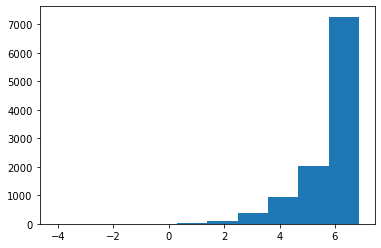

In [560]:
plt.hist(bm25.idf)

In [521]:
sorted(bm25.idf)

[-4.113660351521392,
 -3.953688280650899,
 -2.729421685096848,
 -1.9096407415366123,
 -1.8854942253114977,
 -1.7273721082449551,
 -0.9806724025683021,
 -0.846646076104719,
 -0.3062733125616635,
 -0.2922751908612463,
 -0.112369974569859,
 -0.024641903936928982,
 0.057510712592931834,
 0.10687780217412102,
 0.11236997456985912,
 0.14260944313938453,
 0.21991004322317081,
 0.25322680716693297,
 0.3287329859847597,
 0.3739059858209091,
 0.6854568068469298,
 0.8239391341095753,
 0.8433896971324452,
 0.8531715923992976,
 0.882752090745008,
 0.9362601191435632,
 1.0295265278587191,
 1.0940543956362114,
 1.1419770165826633,
 1.1834721232279044,
 1.2181152060211549,
 1.2259025262821408,
 1.23372311113103,
 1.2494658998969892,
 1.2534231071484532,
 1.2975415818617249,
 1.3097680081018872,
 1.317966931525361,
 1.3978849609348005,
 1.40219841437228,
 1.463811814926233,
 1.4955258794428234,
 1.5514272879774667,
 1.5514272879774667,
 1.5514272879774667,
 1.556178049074509,
 1.5898534431579112,
 1.59

In [513]:
bm25.vectorizer.vocabulary_

{'the': 9777,
 'present': 7613,
 'study': 9404,
 'is': 5474,
 'a': 492,
 'history': 4794,
 'of': 6825,
 'dewey': 3114,
 'decimal': 2877,
 'classification': 2000,
 'first': 4181,
 'edition': 3484,
 'ddc': 2842,
 'was': 10526,
 'published': 7892,
 'in': 5013,
 '1876': 115,
 'eighteenth': 3519,
 '1971': 203,
 'and': 927,
 'future': 4437,
 'editions': 3485,
 'will': 10623,
 'continue': 2513,
 'to': 9906,
 'appear': 1005,
 'as': 1118,
 'needed': 6538,
 'spite': 9237,
 'ddcs': 2844,
 'long': 5903,
 'healthy': 4713,
 'life': 5813,
 'however': 4846,
 'its': 5515,
 'full': 4397,
 'story': 9358,
 'has': 4694,
 'never': 6581,
 'been': 1382,
 'told': 9913,
 'there': 9797,
 'have': 4699,
 'biographies': 1477,
 'that': 9776,
 'briefly': 1608,
 'describe': 3027,
 'his': 4787,
 'system': 9627,
 'but': 1674,
 'this': 9834,
 'attempt': 1220,
 'provide': 7861,
 'detailed': 3070,
 'work': 10666,
 'more': 6408,
 'than': 9774,
 'any': 986,
 'other': 6981,
 'spurred': 9252,
 'growth': 4621,
 'librarianship':